# Pix2Pix GAN Tutorial

## Introduction

This tutorial demonstrates how to build and train a conditional generative adversarial network (CGAN) called Pix2Pix GAN that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). Pix2Pix GAN is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In this tutorial, we will implement Pix2Pix GAN to train a model, which can translate semantic labeled images of building facades to photographs using the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/).

In the Pix2Pix GAN, a model conditions on input images and generates corresponding output images. 

The architecture of  the Pix2Pix GAN will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).


Below are some examples of the output generated by the Pix2Pix GAN.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)



## Install MMGeneration in CS GPU farm

## Verify MMGeneration in CS GPU farm

1. Create a conda virtual environment and activate it. (Here, we assume the new environment is called ``open-mmlab``)

    ```shell
    conda create -n open-mmlab python=3.7 -y
    conda activate open-mmlab
    ```  
    

2. Install PyTorch and torchvision following the [official instructions](https://pytorch.org/),

    ```shell
    conda install pytorch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 cudatoolkit=10.1 -c pytorch
    ```  
    

3. Install mmcv-full from source by the following command

    ```shell
    git clone https://github.com/open-mmlab/mmcv.git
    cd mmcv
    MMCV_WITH_OPS=1 pip install -e .  # package mmcv-full will be installed after this step
    cd ..
    ```  
    

4. Clone the MMGeneration repository.

    ```shell
    git clone https://github.com/open-mmlab/mmgeneration.git
    cd mmgeneration
    ```  
    

5. Install build requirements and then install MMGeneration.

    ```shell
    pip install -r requirements.txt
    pip install -v -e .  # or "python setup.py develop"
    ```  
    

Use load_from_http loader


2021-09-26 20:28:15,302 - mmgen - INFO - Switch to evaluation style mode: single
2021-09-26 20:28:15,303 - mmgen - INFO - Switch to evaluation style mode: single


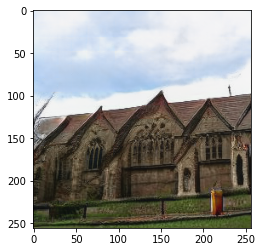

In [ ]:
from  matplotlib import pyplot as plt
import numpy as np

from mmgen.apis import init_model, sample_uncoditional_model

config_file = 'configs/styleganv2/stylegan2_c2_lsun-church_256_b4x8_800k.py'
# you can download this checkpoint in advance and use a local file path.
checkpoint_file = 'https://download.openmmlab.com/mmgen/stylegan2/official_weights/stylegan2-church-config-f-official_20210327_172657-1d42b7d1.pth'
device = 'cuda:0'
# init a generatvie
model = init_model(config_file, checkpoint_file, device=device)
# sample images
fake_imgs = sample_uncoditional_model(model, 1)

fake_img = fake_imgs[0].cpu().numpy()
fake_img = np.transpose(fake_img, (1,2,0))
min_ = fake_img.min()
max_ = fake_img.max()
fake_img = (fake_img - min_) / (max_ - min_)
fake_img = fake_img[:,:,::-1]
plt.imshow(fake_img)
plt.show()

## Prepare Data

We use CMP Facade Dataset, which contains facade images assembled at the Center for Machine Perception. It includes 606 rectified images of facades from various sources, which have been manually annotated. The facades are from different cities around the world and diverse architectural styles. In the dataset, every image is formed by concatenating two corresponding images from two domains along the width dimension, as shown below.

![image.png](attachment:b6b5fcfd-3f8f-4358-ac31-b2a15426f52c.png)

1. Download http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz to the local computer.  

2. Unzip facades.tar.gz in the local computer.  

3. Run 'hostname -I' on the GPU compute node find out IP address.  

4. Run 'sftp \<your_cs_username\>@10.XXX.XXX.XXX' to login in the sftp server.

5. Run 'put -r xxx/facades \<your_destination\>' to upload the dataset to the gpu farm.  

6. Copy facades to the folder './data/paired'.


## Training Pix2Pix GAN

### Build the Generator
The generator of your Pix2Pix GAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). 

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

### Build the Discriminator
The discriminator in the Pix2Pix GAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.

### Define the Generator Loss
GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. 

### Define the Discriminator Loss
- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

Now you can train your own Pix2Pix GAN.

In [ ]:
import argparse
import copy
import os
import os.path as osp
import time

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmgen import __version__
from mmgen.apis import set_random_seed, train_model
from mmgen.datasets import build_dataset
from mmgen.models import build_model
from mmgen.utils import collect_env, get_root_logger


def parse_args():
    parser = argparse.ArgumentParser(description='Train a GAN model')
    parser.add_argument('--config', default='configs/pix2pix/pix2pix_vanilla_unet_bn_1x1_80k_facades.py', help='train config file path')
    parser.add_argument('--work-dir', default='./work_dirs/experiments/facades_train',help='the dir to save logs and models')
    parser.add_argument(
        '--resume-from', help='the checkpoint file to resume from')
    parser.add_argument(
        '--no-validate',
        action='store_true',
        help='whether not to evaluate the checkpoint during training')
    group_gpus = parser.add_mutually_exclusive_group()
    group_gpus.add_argument(
        '--gpus',
        type=int,
        help='number of gpus to use '
        '(only applicable to non-distributed training)')
    group_gpus.add_argument(
        '--gpu-ids',
        type=int,
        nargs='+',
        help='ids of gpus to use '
        '(only applicable to non-distributed training)')
    parser.add_argument('--seed', type=int, default=2021, help='random seed')
    parser.add_argument(
        '--deterministic',
        action='store_true',
        help='whether to set deterministic options for CUDNN backend.')
    parser.add_argument(
        '--cfg-options',
        nargs='+',
        action=DictAction,
        help='override some settings in the used config, the key-value pair '
        'in xxx=yyy format will be merged into config file.')
    parser.add_argument(
        '--launcher',
        choices=['none', 'pytorch', 'slurm', 'mpi'],
        default='none',
        help='job launcher')
    parser.add_argument('--local_rank', type=int, default=0)
    args = parser.parse_args(args=[])
    if 'LOCAL_RANK' not in os.environ:
        os.environ['LOCAL_RANK'] = str(args.local_rank)

    return args


def main():
    args = parse_args()

    cfg = Config.fromfile(args.config)
    if args.cfg_options is not None:
        cfg.merge_from_dict(args.cfg_options)
    # import modules from string list.
    if cfg.get('custom_imports', None):
        from mmcv.utils import import_modules_from_strings
        import_modules_from_strings(**cfg['custom_imports'])
    # set cudnn_benchmark
    if cfg.get('cudnn_benchmark', False):
        torch.backends.cudnn.benchmark = True

    # work_dir is determined in this priority: CLI > segment in file > filename
    if args.work_dir is not None:
        # update configs according to CLI args if args.work_dir is not None
        cfg.work_dir = args.work_dir
    elif cfg.get('work_dir', None) is None:
        # use config filename as default work_dir if cfg.work_dir is None
        cfg.work_dir = osp.join('./work_dirs',
                                osp.splitext(osp.basename(args.config))[0])
    if args.resume_from is not None:
        cfg.resume_from = args.resume_from
    if args.gpu_ids is not None:
        cfg.gpu_ids = args.gpu_ids
    else:
        cfg.gpu_ids = range(1) if args.gpus is None else range(args.gpus)

    # init distributed env first, since logger depends on the dist info.
    if args.launcher == 'none':
        distributed = False
    else:
        distributed = True
        init_dist(args.launcher, **cfg.dist_params)
        # re-set gpu_ids with distributed training mode
        _, world_size = get_dist_info()
        cfg.gpu_ids = range(world_size)

    # create work_dir
    mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
    # dump config
    cfg.dump(osp.join(cfg.work_dir, osp.basename(args.config)))
    # init the logger before other steps
    timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
    log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
    logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

    # init the meta dict to record some important information such as
    # environment info and seed, which will be logged
    meta = dict()
    # log env info
    env_info_dict = collect_env()
    env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
    dash_line = '-' * 60 + '\n'
    logger.info('Environment info:\n' + dash_line + env_info + '\n' +
                dash_line)
    meta['env_info'] = env_info
    meta['config'] = cfg.pretty_text
    # log some basic info
    logger.info(f'Distributed training: {distributed}')
    logger.info(f'Config:\n{cfg.pretty_text}')

    # set random seeds
    if args.seed is not None:
        logger.info(f'Set random seed to {args.seed}, '
                    f'deterministic: {args.deterministic}')
        set_random_seed(args.seed, deterministic=args.deterministic)
    cfg.seed = args.seed
    meta['seed'] = args.seed
    meta['exp_name'] = osp.basename(args.config)

    model = build_model(
        cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

    datasets = [build_dataset(cfg.data.train)]
    if len(cfg.workflow) == 2:
        val_dataset = copy.deepcopy(cfg.data.val)
        val_dataset.pipeline = cfg.data.train.pipeline
        datasets.append(build_dataset(val_dataset))
    if cfg.checkpoint_config is not None:
        # save mmgen version, config file content and class names in
        # checkpoints as meta data
        cfg.checkpoint_config.meta = dict(mmgen_version=__version__ +
                                          get_git_hash()[:7])

    train_model(
        model,
        datasets,
        cfg,
        distributed=distributed,
        validate=(not args.no_validate),
        timestamp=timestamp,
        meta=meta)


if __name__ == '__main__':
    main()


2021-09-26 16:40:46,219 - mmgen - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.11 (default, Jul 27 2021, 14:32:16) [GCC 7.5.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.2.r11.2/compiler.29618528_0
GPU 0: NVIDIA GeForce GTX 1080 Ti
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.7.1
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.3-Product Build 20210617 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.6.0 (Git Hash 5ef631a030a6f73131c77892041042805a06064f)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-genc

## Testing

We can now translate semantic labeled images of building facades to photographs with the trained model.

In [ ]:
import argparse
import os
import sys

import mmcv
from mmcv import DictAction
from torchvision import utils

from mmgen.apis import init_model, sample_img2img_model  



def parse_args():

    parser = argparse.ArgumentParser(description='Translation demo')

    parser.add_argument('--config', default='./configs/pix2pix/pix2pix_vanilla_unet_bn_1x1_80k_facades.py', help='test config file path')
    parser.add_argument('--checkpoint', default='./work_dirs/experiments/facades_train/ckpt/latest.pth', help='checkpoint file')
    parser.add_argument('--image_path', default='./data/paired/facades/test/3.jpg', help='Image file path')
    parser.add_argument(
        '--target-domain', type=str, default=None, help='Desired image domain')
    parser.add_argument(
        '--save-path',
        type=str,
        default='./fake_images/3.jpg',
        help='path to save translation sample')
    parser.add_argument(
        '--device', type=str, default='cuda:0', help='CUDA device id')
    # args for inference/sampling
    parser.add_argument(
        '--sample-cfg',
        nargs='+',
        action=DictAction,
        help='Other customized kwargs for sampling function')
    args = parser.parse_args(args=[])
    return args



def main():
    args = parse_args()
    model = init_model(
        args.config, checkpoint=args.checkpoint, device=args.device)

    if args.sample_cfg is None:
        args.sample_cfg = dict()

    results = sample_img2img_model(model, args.image_path, args.target_domain,
                                   **args.sample_cfg)
    results = (results[:, [2, 1, 0]] + 1.) / 2.

    # save images
    mmcv.mkdir_or_exist(os.path.dirname(args.save_path))
    utils.save_image(results, args.save_path)


if __name__ == '__main__':
    main()

![image.png](attachment:6c755569-0efe-46fb-8752-7807decb4d28.png) ![image.png](attachment:ecf523cb-27bd-4289-9714-c9bb4aa6f592.png)

# Project: Generating street scenes from semantic labels

## Requirement
In this project, you need to train a Pix2Pix GAN model with the training set of Cityscapes Dataset as shown below. After training the model, you need to generate street scenes from semantic labels of the Cityscapes test set. 

![13.jpg](attachment:13.jpg)

## Data
Download http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/cityscapes.tar.gz. 2975 pairs in the "train" folder are used for training, and 500 pairs in the "val" folder are used for testing.


## Training
Please fill in the training code and finish the training process of your Pix2Pix GAN model.

## Testing
Please fill in the testing code and generate street scenes from semantic labels of the test set of Cityscapes Dataset.